<a href="https://colab.research.google.com/github/dbtjr1103/Basic_practice/blob/main/food12_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# data download from google drive

food data
- label : 12
- label_names = 'apple_pie', 'cheesecake', 'pizza', 'waffles', 'ramen', 'bibimbap', 'fried_rice', 'club_sandwich', 'hamburger', 'hot_dog', 'sashimi', 'sushi'
- resized : 224 * 224 * 3
- dataset : train 700, val 200, test 100

In [1]:
!pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [2]:
!gdown 1--zzEz-AUajDmmXsVeBMVOks3aJ6yeXJ

Downloading...
From: https://drive.google.com/uc?id=1--zzEz-AUajDmmXsVeBMVOks3aJ6yeXJ
To: /content/food12_dataset.zip
100% 285M/285M [00:05<00:00, 51.5MB/s]


In [3]:
!unzip -q food12_dataset.zip

# data handling

In [1]:
import os

import cv2
import numpy as np
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
folder_path = '/content/dataset/train'
label_names = os.listdir(folder_path)
label_names

['fried_rice',
 'waffles',
 'sushi',
 'hamburger',
 'cheesecake',
 'apple_pie',
 'club_sandwich',
 'hot_dog',
 'sashimi',
 'bibimbap',
 'ramen',
 'pizza']

In [3]:
label2index = {}
for idx, label in enumerate(label_names):
    label2index[label] = idx
label2index

{'fried_rice': 0,
 'waffles': 1,
 'sushi': 2,
 'hamburger': 3,
 'cheesecake': 4,
 'apple_pie': 5,
 'club_sandwich': 6,
 'hot_dog': 7,
 'sashimi': 8,
 'bibimbap': 9,
 'ramen': 10,
 'pizza': 11}

In [4]:
folder_path = '/content/dataset/train'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [5]:
x_train, y_train = [], []

for label, filenames in tqdm(dataset.items()):
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_train.append(image)
        y_train.append(label2index[label]) # label을 index로 변경

  0%|          | 0/12 [00:00<?, ?it/s]

In [6]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [7]:
# x_train = x_train.astype('float32')
x_train = x_train.astype('int8') # float시 메모리 부족으로 학습 불가

In [8]:
x_train.shape, y_train.shape

((8400, 224, 224, 3), (8400,))

In [9]:
folder_path = '/content/dataset/val'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [10]:
x_val, y_val = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_val.append(image)
        y_val.append(label2index[label]) # label을 index로 변경

In [11]:
x_val, y_val= np.array(x_val), np.array(y_val)

In [12]:
x_val = x_val.astype('int8')

In [13]:
x_val.shape, y_val.shape

((2400, 224, 224, 3), (2400,))

In [14]:
folder_path = '/content/dataset/test'
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in os.listdir(folder_path):
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

In [15]:
x_test, y_test = [], []

for label, filenames in dataset.items():
    for filename in filenames:
        image = cv2.imread(filename) # img를 array 형태로 변경

        x_test.append(image)
        y_test.append(label2index[label]) # label을 index로 변경

In [16]:
x_test, y_test= np.array(x_test), np.array(y_test)

In [17]:
x_test = x_test.astype('int8')

In [18]:
x_test.shape, y_test.shape

((1200, 224, 224, 3), (1200,))

In [19]:
def zero_mean(image):
    # zero-centering
    return np.mean(image, axis=0)

# zero_mean_img = zero_mean(x_train)
zero_mean_img = zero_mean(x_train).astype('int8')

In [20]:
x_train -= zero_mean_img
x_val -= zero_mean_img
x_test -= zero_mean_img

In [21]:
# x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0 

# Model handling

In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import datasets, layers, models, Input
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

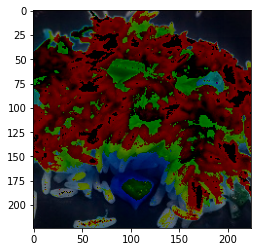

In [22]:
plt.figure()
plt.imshow(x_train[0])
plt.show()

In [23]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((8400, 224, 224, 3),
 (8400,),
 (2400, 224, 224, 3),
 (2400,),
 (1200, 224, 224, 3),
 (1200,))

In [24]:
y_train = y_train.reshape((8400,1))
y_val = y_val.reshape((2400,1))
y_test = y_test.reshape((1200,1))

## ResNet50

In [26]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [27]:
model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet')
print(len(model.layers))

175


In [28]:
model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = model(inputs, training=False)

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 512)               524800

Epoch 1/30
66/66 [==============================] - 43s 552ms/step - loss: 10.3452 - accuracy: 0.1504 - val_loss: 2.2573 - val_accuracy: 0.2375
Epoch 2/30
66/66 [==============================] - 34s 520ms/step - loss: 2.3108 - accuracy: 0.1914 - val_loss: 2.1663 - val_accuracy: 0.2600
Epoch 3/30
66/66 [==============================] - 33s 502ms/step - loss: 2.1515 - accuracy: 0.2426 - val_loss: 1.9593 - val_accuracy: 0.3487
Epoch 4/30
66/66 [==============================] - 34s 513ms/step - loss: 2.0203 - accuracy: 0.2938 - val_loss: 1.7954 - val_accuracy: 0.3775
Epoch 5/30
66/66 [==============================] - 33s 506ms/step - loss: 1.9087 - accuracy: 0.3221 - val_loss: 1.7743 - val_accuracy: 0.4142
Epoch 6/30
66/66 [==============================] - 34s 509ms/step - loss: 1.8442 - accuracy: 0.3408 - val_loss: 1.7739 - val_accuracy: 0.3787
Epoch 7/30
66/66 [==============================] - 33s 508ms/step - loss: 1.7949 - accuracy: 0.3608 - val_loss: 1.7164 - val_accuracy: 0.431

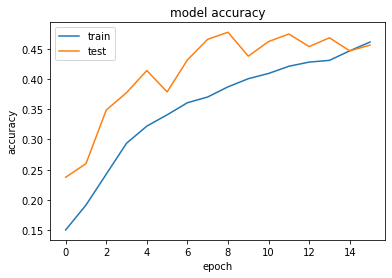

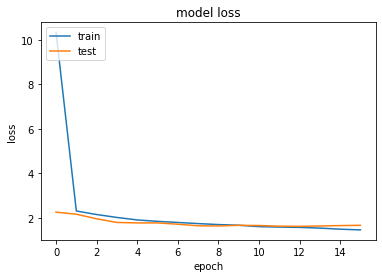

In [29]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

results = model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=128, callbacks=[early])
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### underfit, pooling층 추가


In [30]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [31]:
model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = model(inputs, training=False)

x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)

x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])

print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 1024)              2098176   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_6 (Dense)             (None, 512)               5248

In [32]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=128, callbacks=[early])

Epoch 1/30
66/66 [==============================] - 34s 473ms/step - loss: 2.1464 - accuracy: 0.2970 - val_loss: 1.6609 - val_accuracy: 0.4425
Epoch 2/30
66/66 [==============================] - 32s 486ms/step - loss: 1.5961 - accuracy: 0.4606 - val_loss: 1.4454 - val_accuracy: 0.5083
Epoch 3/30
66/66 [==============================] - 31s 476ms/step - loss: 1.4818 - accuracy: 0.5012 - val_loss: 1.4155 - val_accuracy: 0.5358
Epoch 4/30
66/66 [==============================] - 31s 479ms/step - loss: 1.4083 - accuracy: 0.5271 - val_loss: 1.3567 - val_accuracy: 0.5521
Epoch 5/30
66/66 [==============================] - 32s 480ms/step - loss: 1.3411 - accuracy: 0.5532 - val_loss: 1.3402 - val_accuracy: 0.5512
Epoch 6/30
66/66 [==============================] - 31s 478ms/step - loss: 1.3032 - accuracy: 0.5630 - val_loss: 1.3167 - val_accuracy: 0.5571
Epoch 7/30
66/66 [==============================] - 32s 481ms/step - loss: 1.2644 - accuracy: 0.5725 - val_loss: 1.3236 - val_accuracy: 0.5529

### layer 추가


In [36]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [37]:
model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_13 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_4 (Dropout)         (None, 1024)              0         
                                                                 
 dense_14 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_15 (Dense)            (None, 512)               5248

In [38]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=128, callbacks=[early])

Epoch 1/30
66/66 [==============================] - 35s 485ms/step - loss: 2.1540 - accuracy: 0.2423 - val_loss: 1.7281 - val_accuracy: 0.4175
Epoch 2/30
66/66 [==============================] - 32s 492ms/step - loss: 1.6671 - accuracy: 0.4354 - val_loss: 1.5314 - val_accuracy: 0.4904
Epoch 3/30
66/66 [==============================] - 31s 474ms/step - loss: 1.4944 - accuracy: 0.5035 - val_loss: 1.4439 - val_accuracy: 0.5129
Epoch 4/30
66/66 [==============================] - 32s 483ms/step - loss: 1.4077 - accuracy: 0.5364 - val_loss: 1.4374 - val_accuracy: 0.5233
Epoch 5/30
66/66 [==============================] - 32s 479ms/step - loss: 1.3500 - accuracy: 0.5489 - val_loss: 1.3971 - val_accuracy: 0.5375
Epoch 6/30
66/66 [==============================] - 32s 482ms/step - loss: 1.2886 - accuracy: 0.5720 - val_loss: 1.3531 - val_accuracy: 0.5654
Epoch 7/30
66/66 [==============================] - 32s 481ms/step - loss: 1.2516 - accuracy: 0.5839 - val_loss: 1.3729 - val_accuracy: 0.5429

### layer 추가


In [47]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [48]:
model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_39 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_8 (Dropout)         (None, 1024)              0         
                                                                 
 dense_40 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_41 (Dense)            (None, 1024)              1049

In [49]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=128, callbacks=[early])

Epoch 1/30
66/66 [==============================] - 37s 510ms/step - loss: 2.2654 - accuracy: 0.2198 - val_loss: 1.7727 - val_accuracy: 0.4054
Epoch 2/30
66/66 [==============================] - 31s 474ms/step - loss: 1.7825 - accuracy: 0.3942 - val_loss: 1.5793 - val_accuracy: 0.4742
Epoch 3/30
66/66 [==============================] - 32s 480ms/step - loss: 1.6142 - accuracy: 0.4656 - val_loss: 1.4654 - val_accuracy: 0.5288
Epoch 4/30
66/66 [==============================] - 32s 483ms/step - loss: 1.5179 - accuracy: 0.5044 - val_loss: 1.4148 - val_accuracy: 0.5346
Epoch 5/30
66/66 [==============================] - 31s 477ms/step - loss: 1.4615 - accuracy: 0.5208 - val_loss: 1.3987 - val_accuracy: 0.5446
Epoch 6/30
66/66 [==============================] - 32s 483ms/step - loss: 1.4317 - accuracy: 0.5388 - val_loss: 1.3843 - val_accuracy: 0.5454
Epoch 7/30
66/66 [==============================] - 32s 479ms/step - loss: 1.3946 - accuracy: 0.5460 - val_loss: 1.3916 - val_accuracy: 0.5558

### 재학습층 40


In [51]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [52]:
model.trainable = True
for layer in model.layers[:-40]: 
  layer.trainable = False	
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_48 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                                 
 dense_49 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_50 (Dense)            (None, 512)               5248

In [53]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=128, callbacks=[early])

Epoch 1/30
66/66 [==============================] - 49s 655ms/step - loss: 2.6335 - accuracy: 0.0956 - val_loss: 2.5037 - val_accuracy: 0.0833
Epoch 2/30
66/66 [==============================] - 39s 599ms/step - loss: 2.4681 - accuracy: 0.1068 - val_loss: 2.4041 - val_accuracy: 0.1346
Epoch 3/30
66/66 [==============================] - 40s 611ms/step - loss: 2.3318 - accuracy: 0.1436 - val_loss: 2.1931 - val_accuracy: 0.1708
Epoch 4/30
66/66 [==============================] - 40s 604ms/step - loss: 2.1401 - accuracy: 0.2044 - val_loss: 2.0788 - val_accuracy: 0.2196
Epoch 5/30
66/66 [==============================] - 40s 610ms/step - loss: 1.9028 - accuracy: 0.2976 - val_loss: 1.9600 - val_accuracy: 0.2958
Epoch 6/30
66/66 [==============================] - 40s 608ms/step - loss: 1.6486 - accuracy: 0.4174 - val_loss: 1.6349 - val_accuracy: 0.4346
Epoch 7/30
66/66 [==============================] - 40s 605ms/step - loss: 1.3533 - accuracy: 0.5348 - val_loss: 1.4789 - val_accuracy: 0.5188

In [ ]:
# 재학습되면서 바로 오버핏...?

### 재학습층 20, layer줄임


In [54]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [55]:
model.trainable = True
for layer in model.layers[:-20]: 
  layer.trainable = False	
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                                 
 dense_52 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                                 
 dense_53 (Dense)            (None, 12)                12300     
                                                                 
Total params: 25,698,188
Trainable params: 9,992,716
Non-t

In [56]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=128, callbacks=[early])

Epoch 1/30
66/66 [==============================] - 41s 571ms/step - loss: 1.9464 - accuracy: 0.3610 - val_loss: 1.4830 - val_accuracy: 0.4983
Epoch 2/30
66/66 [==============================] - 34s 520ms/step - loss: 1.2743 - accuracy: 0.5837 - val_loss: 1.2521 - val_accuracy: 0.6071
Epoch 3/30
66/66 [==============================] - 35s 530ms/step - loss: 1.0054 - accuracy: 0.6710 - val_loss: 1.2434 - val_accuracy: 0.6092
Epoch 4/30
66/66 [==============================] - 35s 525ms/step - loss: 0.7667 - accuracy: 0.7493 - val_loss: 1.2376 - val_accuracy: 0.6154
Epoch 5/30
66/66 [==============================] - 35s 527ms/step - loss: 0.5517 - accuracy: 0.8198 - val_loss: 1.2676 - val_accuracy: 0.6350
Epoch 6/30
66/66 [==============================] - 35s 528ms/step - loss: 0.3543 - accuracy: 0.8850 - val_loss: 1.3638 - val_accuracy: 0.6204
Epoch 7/30
66/66 [==============================] - 35s 527ms/step - loss: 0.2382 - accuracy: 0.9229 - val_loss: 1.6838 - val_accuracy: 0.6175

### batch size 줄임 128->96 (최고성능)
val_loss: 1.2000 - val_accuracy: 0.6121



In [58]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [59]:
model.trainable = True
for layer in model.layers[:-20]: 
  layer.trainable = False	
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_12 (Flatten)        (None, 2048)              0         
                                                                 
 dense_56 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_14 (Dropout)        (None, 1024)              0         
                                                                 
 dense_57 (Dense)            (None, 12)                12300     
                                                                 
Total params: 25,698,188
Trainable params: 9,992,716
Non-t

In [60]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=96, callbacks=[early])

Epoch 1/30
88/88 [==============================] - 42s 436ms/step - loss: 1.8838 - accuracy: 0.3780 - val_loss: 1.3966 - val_accuracy: 0.5450
Epoch 2/30
88/88 [==============================] - 35s 394ms/step - loss: 1.2302 - accuracy: 0.5895 - val_loss: 1.2724 - val_accuracy: 0.5908
Epoch 3/30
88/88 [==============================] - 35s 401ms/step - loss: 0.9537 - accuracy: 0.6869 - val_loss: 1.2000 - val_accuracy: 0.6121
Epoch 4/30
88/88 [==============================] - 35s 400ms/step - loss: 0.7119 - accuracy: 0.7680 - val_loss: 1.2173 - val_accuracy: 0.6296
Epoch 5/30
88/88 [==============================] - 35s 399ms/step - loss: 0.5097 - accuracy: 0.8311 - val_loss: 1.3539 - val_accuracy: 0.6233
Epoch 6/30
88/88 [==============================] - 35s 402ms/step - loss: 0.3167 - accuracy: 0.8939 - val_loss: 1.4058 - val_accuracy: 0.6371


### batch size 더 줄임 64
val_loss: 1.2062 - val_accuracy: 0.6092



In [61]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [62]:
model.trainable = True
for layer in model.layers[:-20]: 
  layer.trainable = False	
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_27 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_13 (Flatten)        (None, 2048)              0         
                                                                 
 dense_58 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_15 (Dropout)        (None, 1024)              0         
                                                                 
 dense_59 (Dense)            (None, 12)                12300     
                                                                 
Total params: 25,698,188
Trainable params: 9,992,716
Non-t

In [63]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=64, callbacks=[early])

Epoch 1/30
132/132 [==============================] - 43s 288ms/step - loss: 1.8220 - accuracy: 0.3942 - val_loss: 1.5443 - val_accuracy: 0.4921
Epoch 2/30
132/132 [==============================] - 34s 259ms/step - loss: 1.2322 - accuracy: 0.5919 - val_loss: 1.2062 - val_accuracy: 0.6092
Epoch 3/30
132/132 [==============================] - 35s 263ms/step - loss: 0.9527 - accuracy: 0.6902 - val_loss: 1.2095 - val_accuracy: 0.6067
Epoch 4/30
132/132 [==============================] - 34s 262ms/step - loss: 0.6991 - accuracy: 0.7660 - val_loss: 1.3804 - val_accuracy: 0.6037
Epoch 5/30
132/132 [==============================] - 35s 262ms/step - loss: 0.4908 - accuracy: 0.8377 - val_loss: 1.3406 - val_accuracy: 0.6329


### 최고성능 -> weight 조금씩 변경
dense 1024->512 (x)
256 추가 (x)
...

In [72]:
model = ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet', pooling='avg')
print(len(model.layers))

176


In [73]:
model.trainable = True
for layer in model.layers[:-20]: 
  layer.trainable = False	
inputs = tf.keras.Input(shape=(224, 224, 3))
x = model(inputs, training=False)
x = tf.keras.layers.Flatten(input_shape=model.output_shape[1:])(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(12, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer = 'adam',
                  loss = 'sparse_categorical_crossentropy',
                  metrics=['accuracy'])
print(model.summary())

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_17 (Flatten)        (None, 2048)              0         
                                                                 
 dense_67 (Dense)            (None, 1024)              2098176   
                                                                 
 dropout_20 (Dropout)        (None, 1024)              0         
                                                                 
 dense_68 (Dense)            (None, 256)               262400    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0  

In [74]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=1, min_lr=0) # reduce_lr 은 추후 세부적으로 높일 때 사용
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
model.fit(x_train, y_train, epochs = 30, validation_data=(x_val,y_val), batch_size=96, callbacks=[early])

Epoch 1/30
88/88 [==============================] - 40s 421ms/step - loss: 2.2343 - accuracy: 0.2369 - val_loss: 1.8387 - val_accuracy: 0.3746
Epoch 2/30
88/88 [==============================] - 35s 397ms/step - loss: 1.5904 - accuracy: 0.4677 - val_loss: 1.4979 - val_accuracy: 0.5117
Epoch 3/30
88/88 [==============================] - 35s 401ms/step - loss: 1.3011 - accuracy: 0.5810 - val_loss: 1.3115 - val_accuracy: 0.5767
Epoch 4/30
88/88 [==============================] - 35s 402ms/step - loss: 1.0561 - accuracy: 0.6681 - val_loss: 1.2837 - val_accuracy: 0.5950
Epoch 5/30
88/88 [==============================] - 35s 399ms/step - loss: 0.8375 - accuracy: 0.7323 - val_loss: 1.3238 - val_accuracy: 0.6062
Epoch 6/30
88/88 [==============================] - 35s 400ms/step - loss: 0.6649 - accuracy: 0.7885 - val_loss: 1.3875 - val_accuracy: 0.5867
Epoch 7/30
88/88 [==============================] - 35s 402ms/step - loss: 0.4968 - accuracy: 0.8388 - val_loss: 1.4648 - val_accuracy: 0.6171

## EfficentNetBO

# test

In [12]:
!pip install split-folders
!pip install -q kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [13]:
# .kaggle 폴더 생성
!mkdir -p ~/.kaggle/
# kaggle.josn .kaggle로 복사
!cp kaggle.json ~/.kaggle/
# 해당 폴더 목록 확인(복사 잘 되었는지 확인)
!ls ~/.kaggle

kaggle.json


In [14]:
cd ~

/root


In [15]:
!chmod 600 ~/.kaggle/kaggle.json

In [16]:
cd /content

/content


In [17]:
!kaggle datasets download -d kmader/food41

100% 5.30G/5.30G [02:56<00:00, 34.4MB/s]
100% 5.30G/5.30G [02:56<00:00, 32.2MB/s]


In [20]:
!unzip -q food41.zip

In [21]:
import splitfolders

import os

import cv2
import numpy as np
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

import pickle

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [22]:
label_names = ['apple_pie', 'cheesecake', 'pizza', 'waffles', 'ramen', 'bibimbap', 'fried_rice', 'club_sandwich', 'hamburger', 'hot_dog', 'sashimi', 'sushi']
len(label_names)

12

In [25]:
folder_path = '/content/images'

In [26]:
dataset = {}

# 이미지와 라벨 리스트에 담기
for label in label_names:
    sub_path = folder_path+'/'+label+'/'
    dataset[label] = []
    for filename in os.listdir(sub_path):
        dataset[label].append(sub_path+filename)

dataset

{'apple_pie': ['/content/images/apple_pie/3503020.jpg',
  '/content/images/apple_pie/3214508.jpg',
  '/content/images/apple_pie/1088809.jpg',
  '/content/images/apple_pie/1595134.jpg',
  '/content/images/apple_pie/3549466.jpg',
  '/content/images/apple_pie/3203950.jpg',
  '/content/images/apple_pie/1332030.jpg',
  '/content/images/apple_pie/874809.jpg',
  '/content/images/apple_pie/2725375.jpg',
  '/content/images/apple_pie/3267436.jpg',
  '/content/images/apple_pie/693210.jpg',
  '/content/images/apple_pie/64846.jpg',
  '/content/images/apple_pie/937118.jpg',
  '/content/images/apple_pie/1753935.jpg',
  '/content/images/apple_pie/1456028.jpg',
  '/content/images/apple_pie/2881877.jpg',
  '/content/images/apple_pie/2235547.jpg',
  '/content/images/apple_pie/1725573.jpg',
  '/content/images/apple_pie/2402925.jpg',
  '/content/images/apple_pie/2373323.jpg',
  '/content/images/apple_pie/224785.jpg',
  '/content/images/apple_pie/2601590.jpg',
  '/content/images/apple_pie/946403.jpg',
  '/c

In [27]:
len(dataset)

12

In [28]:
!mkdir resized

In [29]:
cd /content/resized

/content/resized


In [30]:
for label in label_names:
    os.mkdir(label) 

In [31]:
# resize 덮어씌우기
for label, filenames in tqdm(dataset.items()):
    for filename in filenames:
        img = cv2.imread(filename)

        # 이미지의 x, y가 128이 넘을 경우 작게해주기
        percent = 1
        if(img.shape[1] > img.shape[0]) :       # 이미지의 가로가 세보다 크면 가로를 128으로 맞추고 세로를 비율에 맞춰서
            percent = 224/img.shape[1]
        else :
            percent = 224/img.shape[0]

        img = cv2.resize(img, dsize=(0, 0), fx=percent, fy=percent, interpolation=cv2.INTER_LINEAR)
                # 이미지 범위 지정
        y,x,h,w = (0,0,img.shape[0], img.shape[1])

        # 그림 주변에 검은색으로 칠하기
        w_x = (224-(w-x))/2  # w_x = (128 - 그림)을 뺀 나머지 영역 크기 [ 그림나머지/2 [그림] 그림나머지/2 ]
        h_y = (224-(h-y))/2

        if(w_x < 0):         # 크기가 -면 0으로 지정.
            w_x = 0
        elif(h_y < 0):
            h_y = 0

        M = np.float32([[1,0,w_x], [0,1,h_y]])  #(2*3 이차원 행렬)
        img_re = cv2.warpAffine(img, M, (224, 224)) #이동변환  
       
        cv2.imwrite('/content/resized/{0}/{1}'.format(label, filename.split("/")[-1]) , img_re)

  0%|          | 0/12 [00:00<?, ?it/s]

In [33]:
import os

def get_files_count(folder_path):
	dirListing = os.listdir(folder_path)
	return len(dirListing)

In [21]:
label_names

['apple_pie',
 'cheesecake',
 'pizza',
 'waffles',
 'ramen',
 'bibimbap',
 'fried_rice',
 'club_sandwich',
 'hamburger',
 'hot_dog',
 'sashimi',
 'sushi']

In [32]:
print(get_files_count('/content/dataset/val/apple_pie'))
print(get_files_count('/content/dataset/val/cheesecake'))
print(get_files_count('/content/dataset/val/pizza'))
print(get_files_count('/content/dataset/val/waffles'))
print(get_files_count('/content/dataset/val/ramen'))
print(get_files_count('/content/dataset/val/bibimbap'))
print(get_files_count('/content/dataset/val/fried_rice'))
print(get_files_count('/content/dataset/val/club_sandwich'))
print(get_files_count('/content/dataset/val/hamburger'))
print(get_files_count('/content/dataset/val/hot_dog'))
print(get_files_count('/content/dataset/val/sashimi'))
print(get_files_count('/content/dataset/val/sushi'))

200
200
200
200
200
200
200
200
200
200
200
200


In [40]:
os.listdir('/content/dataset/')

['dataset']

In [39]:
rmdir /content/dataset/.ipynb_checkpoints

In [32]:
splitfolders.ratio('/content/resized', output='/content/dataset', seed=77, ratio=(0.7, 0.2, 0.1))

Copying files: 12000 files [00:01, 7308.83 files/s]


In [36]:
folder_path = '/content/food12_224' # 각자 원하는 드라이브 경로에 맞게 수정합시다.

In [ ]:
with open(folder_path+'food12_224*224.pickle', 'wb') as f:
    pickle.dump(, f)

In [19]:
import zipfile
import os

In [40]:
os.getcwd()

'/content'

In [23]:
cd /content

/content


In [41]:
import shutil
shutil.make_archive('food12_dataset', 'zip', '/content/dataset')

'/content/resized/food12_dataset.zip'

In [19]:
import shutil
shutil.rmtree('/content/sample_data/')

In [25]:
!gdown 1--zzEz-AUajDmmXsVeBMVOks3aJ6yeXJ

Downloading...
From: https://drive.google.com/uc?id=1--zzEz-AUajDmmXsVeBMVOks3aJ6yeXJ
To: /content/food12_dataset.zip
100% 285M/285M [00:00<00:00, 290MB/s]


In [47]:
pip install -U --no-cache-dir gdown --pre

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [48]:
!gdown 1ejSNtqYeTV52oco4Pp4523mSUFtZoGZh

Downloading...
From: https://drive.google.com/uc?id=1ejSNtqYeTV52oco4Pp4523mSUFtZoGZh
To: /content/food12.zip
100% 285M/285M [00:00<00:00, 370MB/s]
